<a href="https://colab.research.google.com/github/michelleaeh/Dissertation/blob/master/2MyoASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


**The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.**

**Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.**

**The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL**

**If you use this dataset please cite the following papers:**

**@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}**

**@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}**

**Frequency:**

50Hz sampling rate

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns


**Steps:**

1. Combine files
2. Normalize or standardize matrix
3. Apply Butterworth
4. Apply PCA
5. Input to SVM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import scipy as sp
import warnings

from google.colab import files
from mpl_toolkits import mplot3d
from scipy import signal
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from zipfile import ZipFile

# Import zip containing all files
file_name = "/content/2MyoASL.zip"

# Extract all files from zip
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [2]:
# Generate matrices for all combinations of sensors (E=3, A=5, G=7, O=11)
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155]
comb=['e', 'a', 'g', 'o', 'ea', 'eg', 'eo', 'ag', 'ao', 'go', 'eag', 'eao', 'ego', 'ago', 'eago']
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
    'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']

# Initialization of counters
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 
       'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 
       'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 
       'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']
lengths=np.zeros(849, dtype=int)
reps=np.zeros(36,dtype=int)
features=np.zeros(15)
target=np.zeros(15)

fn=np.arange(35)
wordnum=-1
counter=0
n=0

In [3]:
# Combine all files
for w in words:
  repcount=0
  wordnum+=1

  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'

    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      lengths[counter-1]=len(trial)

      # Replace counter with evaluated term
      trial['Word']=wordnum
      #####################for r in range(0,len(trial)):
      #####################  trial.iloc[r,0]=wordnum
      #trial.groupby('Counter')
      ####trial=trial.set_index([pd.Index(range(len(trial))), 'Counter'], append=True).swaplevel(0,1)
      #trial.iloc[0,0]=wordnum
      #####################trial=trial.set_index('Counter', append=True).swaplevel(0,1)
      trial.set_index(['Word','Counter'], inplace=True)
      
      # Combine all trials
      if path=='/content/2MyoASL/allmorning_10.csv':
          matrix=trial
      else:
          #matrix=pd.concat([matrix, trial],keys=[wordnum])
          matrix=pd.concat([matrix,trial])
"""
      # Plot
      if i==10:
        # Create plot for EMG
        emgp, axs=plt.subplots(16,figsize=(30,30))
        for z in emg:
          emgp.suptitle('EMG for ' + w)
          axs[emg.index(z)].plot(trial.loc[:, z].values)
        
        # Create plot for accelerometer
        plt.figure()
        alx=plt.axes(projection='3d')
        alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
        alx.set_title('Accelerometer on left arm for '+w)

        plt.figure()
        arx=plt.axes(projection='3d')
        arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
        arx.set_title('Accelerometer on right arm for '+w)

        # Create plot for gyroscope
        plt.figure()
        glx=plt.axes(projection='3d')
        glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
        glx.set_title('Gyroscope on left arm for '+w)

        plt.figure()
        grx=plt.axes(projection='3d')
        grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
        grx.set_title('Gyroscope on right arm for '+w)

        # Create plot for orientation
        orip, axt=plt.subplots(6,figsize=(30,30))
        for f in ori:
          orip.suptitle('Orientation for ' + w)
          axt[ori.index(f)].plot(trial.loc[:, f].values)

      else:
        # Plot EMG
        for z in emg:
          axs[emg.index(z)].plot(trial.loc[:, z].values)
        
        # Plot accelerometer
        alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
        arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
        
        # Plot gyroscope
        glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
        grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          
        # Plot orientation
        for f in ori:
          axt[ori.index(f)].plot(trial.loc[:, f].values)
        
        warnings.filterwarnings("ignore", category=RuntimeWarning) 
  reps[wordnum]=repcount
warnings.filterwarnings("ignore", category=RuntimeWarning)
"""
print(matrix)

              EMG0L  EMG1L  EMG2L  EMG3L  ...       GZR  ORR  OPR  OYR
Word Counter                              ...                         
0    1            0      0      0      0  ...    6.3750   84  104   84
     2            0      0      0      0  ...   21.3750   84  105   84
     3           -3     -1      5      9  ...   26.6250   87  106   85
     4           -1     13      9      5  ...   70.5000   88  101   86
     5          -31    -10      2     11  ...  118.1250   93   87   89
...             ...    ...    ...    ...  ...       ...  ...  ...  ...
35   46          -2     -1     -4     -1  ...  -82.9375  104  105  179
     47           0     -3      0     -1  ...  -56.1875  103  113  179
     48          -1      3      0      0  ...  -15.5625  103  118  179
     49           1      4      1      0  ...   -3.3750  103  120  179
     50          -1      0     -1     -3  ...    6.2500  102  120    0

[42654 rows x 34 columns]


In [4]:
# Average and standard deviation of each sensor
avg=matrix.mean(axis=0)
sd=matrix.std(axis=0)
pd.concat([avg.rename('Mean'),sd.rename('St. dev.')], axis=1)

,Mean,St. dev.
EMG0L,-9.916538e-01,8.194696e+00
EMG1L,-1.102781e+00,1.196821e+01
EMG2L,-1.093731e+00,1.228857e+01
EMG3L,-1.045224e+00,1.005018e+01
EMG4L,-1.041075e+00,8.165099e+00
EMG5L,-9.889108e-01,8.844608e+00
EMG6L,-1.022272e+00,9.993235e+00
EMG7L,-1.038308e+00,8.800313e+00
AXL,-8.253360e-02,4.236066e-01
AYL,-3.277914e-01,3.371306e-01


In [5]:
attempt=matrix

In [6]:
# Eliminate unnecessary columns to create combinatory matrices
for v in products:
  m=matrix
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  products[n]=m
  exec(comb[n]+"=products[n]")
  n+=1
  
  # Normalize and Standardize each of the 15 matrices
  # Separate features from target values
  x = m.loc[:, m.columns].values   # Features
  ######################y = m.loc[:,'Counter'].values               # Target
  ####y = m.index[m['Word']]

  #y=m.iloc[0]
  #"None of [Index(['Counter'], dtype='object')] are in the [columns]"

  ## Normalize features so that each column is between 0 and 1
  norm_matrix=(m-m.min())/(m.max()-m.min())
  exec("norm_matrix_"+comb[n-1]+"=pd.DataFrame(norm_matrix)")

  # Normalize features
#  normalized_matrix=(x-x.min())/(x.max()-x.min())
#  exec("normalized_matrix_"+comb[n-1]+"=pd.DataFrame(normalized_matrix)")

  # Standardize features with mean=0 and deviation=1
  standardized_matrix=StandardScaler().fit_transform(x)
  exec("standardized_matrix_"+comb[n-1]+"=pd.DataFrame(standardized_matrix)")

  # Save data frames as csv files
  #matrix.to_csv(path_or_buf='/content/matrix_'+comb[n-1]+'.csv')
  exec("norm_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/normmatrix_'+comb[n-1]+'.csv')")
#  exec("normalized_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/normalizedmatrix_'+comb[n-1]+'.csv')")
  exec("standardized_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/standardizedmatrix_'+comb[n-1]+'.csv')")


In [7]:
nmatrix=norm_matrix_eago

In [8]:
# Butterworth
#high = 20/(1000/2)
#low = 450/(1000/2)
high = 1/(50/2)
low = 23/(50/2)

b, a = sp.signal.butter(4, [high,low], btype='bandpass')

for r in emg:
  norm_matrix_eago[[r]]
  # process EMG signal: filter EMG
  emg_filtered = sp.signal.lfilter(b, a, norm_matrix_eago[[r]])
  norm_matrix_eago[[r]]=emg_filtered

In [9]:
buttermatrix=norm_matrix_eago

In [10]:
#data_top=norm_matrix_eago.head()
#list(data_top.index.values)
#####indices=list(norm_matrix_eago.index.values.tolist()) 
#indices=norm_matrix_eago.index.get_level_values('Word')
#print(indices)

**Combinations of steps for classification**

score 0.040675184620794745
pred label [18 18 18 ... 18 18 18]
length 25593


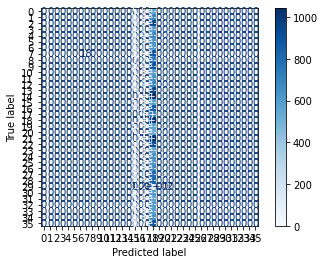

<Figure size 3600x3600 with 0 Axes>

                       precision    recall  f1-score   support

           allmorning       0.00      0.00      0.00       562
                 bird       0.00      0.00      0.00       692
                 blue       0.00      0.00      0.00       946
            cantsleep       0.00      0.00      0.00       608
                  cat       0.00      0.00      0.00       694
        coldrunnynose       0.00      0.00      0.00       629
continuouslyforanhour       0.00      0.00      0.00       611
                 cost       1.00      0.02      0.04       909
                  day       0.00      0.00      0.00       720
               dollar       0.00      0.00      0.00       892
         everymorning       0.00      0.00      0.00       582
           everynight       0.00      0.00      0.00       652
                 gold       0.00      0.00      0.00       689
            goodnight       0.00      0.00      0.00       966
                happy       0.00      0.00      0.00  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Directly to SVM
x = attempt.loc[:, attempt.columns].values   # Features
#y = m.loc[:,['Counter']].values               # Target
y=attempt.index.get_level_values('Word')     # Target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

clf = SVC()
clf.fit(x_train, y_train)
print ('score', clf.score(x_test, y_test))
y_pred=clf.predict(x_test)
print ('pred label', y_pred)
print('length',len(clf.predict(x_test)))

# Confusion matrix
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.figure(figsize=(50,50))
plt.show()

#metrics.classification_report(y_test,y_pred, target_names=words)
print(classification_report(y_test, y_pred, target_names=words))

score 0.4149572148634392
pred label [34 35 31 ... 21  8  9]
length 25593


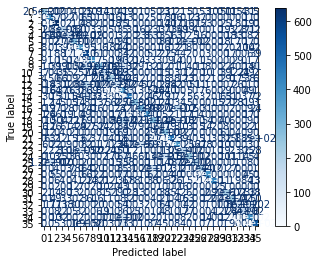

<Figure size 3600x3600 with 0 Axes>

                       precision    recall  f1-score   support

           allmorning       0.80      0.44      0.56       563
                 bird       0.51      0.59      0.55       700
                 blue       0.49      0.66      0.56       962
            cantsleep       0.30      0.31      0.31       597
                  cat       0.40      0.19      0.26       716
        coldrunnynose       0.42      0.43      0.43       628
continuouslyforanhour       0.53      0.58      0.55       616
                 cost       0.28      0.63      0.39       928
                  day       0.75      0.56      0.64       714
               dollar       0.40      0.35      0.37       825
         everymorning       0.50      0.26      0.34       609
           everynight       0.40      0.35      0.37       610
                 gold       0.46      0.18      0.26       702
            goodnight       0.15      0.36      0.22       993
                happy       0.40      0.47      0.43  

In [12]:
# Normalized to SVM
x = nmatrix.loc[:, nmatrix.columns].values   # Features
#y = m.loc[:,['Counter']].values               # Target
y=nmatrix.index.get_level_values('Word')              # Target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

clf = SVC()
clf.fit(x_train, y_train)
print ('score', clf.score(x_test, y_test))
y_pred=clf.predict(x_test)
print ('pred label', y_pred)
print('length',len(clf.predict(x_test)))

# Confusion matrix
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.figure(figsize=(50,50))
plt.show()

#metrics.classification_report(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=words))

score 0.4172234595397179
pred label [ 2 17  1 ... 15 22  5]
length 25593


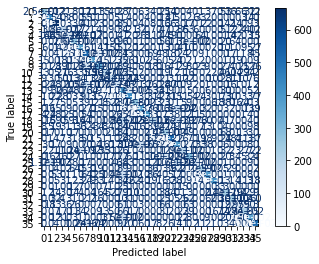

<Figure size 3600x3600 with 0 Axes>

                       precision    recall  f1-score   support

           allmorning       0.76      0.45      0.56       565
                 bird       0.59      0.62      0.60       730
                 blue       0.54      0.69      0.60       969
            cantsleep       0.36      0.29      0.32       623
                  cat       0.33      0.15      0.21       736
        coldrunnynose       0.44      0.44      0.44       599
continuouslyforanhour       0.54      0.56      0.55       643
                 cost       0.29      0.57      0.39       927
                  day       0.77      0.53      0.63       725
               dollar       0.41      0.39      0.40       852
         everymorning       0.47      0.32      0.38       603
           everynight       0.38      0.28      0.32       626
                 gold       0.44      0.18      0.26       656
            goodnight       0.17      0.45      0.24       958
                happy       0.45      0.44      0.44  

In [13]:
# Normalized, Butterworth to SVM
x = buttermatrix.loc[:, buttermatrix.columns].values   # Features
#y = m.loc[:,['Counter']].values               # Target
y=buttermatrix.index.get_level_values('Word')              # Target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

clf = SVC()
clf.fit(x_train, y_train)
print ('score', clf.score(x_test, y_test))
y_pred=clf.predict(x_test)
print ('pred label', y_pred)
print('length',len(clf.predict(x_test)))

# Confusion matrix
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.figure(figsize=(50,50))
plt.show()

#metrics.classification_report(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=words))

Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            ...
            35, 35, 35, 35, 35, 35, 35, 35, 35, 35],
           dtype='int64', name='Word', length=42654)
Normalized matrix
[0.27010181 0.20645315 0.14642317 0.11948544 0.05185246 0.03819654
 0.03251988 0.01669149 0.01380022 0.01179583 0.01077164 0.00949504
 0.00770541 0.0065705  0.00599549 0.00575782 0.00509281 0.00478931
 0.00455997 0.00411447 0.00364114 0.00317156 0.00298551 0.00278929
 0.00260427 0.00212787 0.00192903 0.00165688 0.0016262  0.00134399]
[34.29672279 29.98469513 25.2518837  22.81110787 15.02704469 12.89736254
 11.90044839  8.52582526  7.75232362  7.16725889  6.84904204  6.43039114
  5.79277697  5.34918994  5.10976757  5.00746507  4.70942114  4.56694273
  4.45625125  4.23297873  3.98205782  3.71642544  3.60576817  3.48526474
  3.36768982  3.04412014  2.89839771  2.68617287  2.66119055  2.41928216]


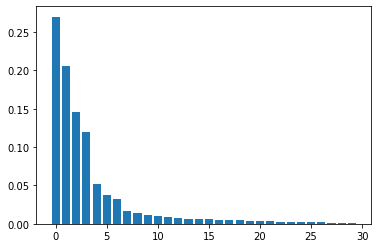

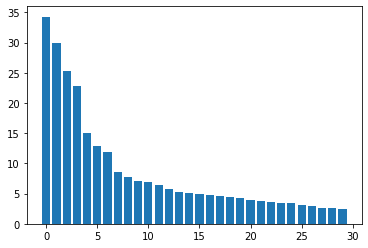

In [14]:
# PCA for norm_matrix
#norm_matrix_eago.reset_index(drop=True, inplace=True)
#m.reset_index(drop=True, inplace=True)

x = norm_matrix_eago.loc[:, norm_matrix_eago.columns].values   # Features
#y = m.loc[:,['Counter']].values               # Target
y=norm_matrix_eago.index.get_level_values('Word')              # Target
print(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

pca = PCA(n_components=30)
pca.fit(x_train)
x_t_train = pca.transform(x_train)
x_t_test = pca.transform(x_test)

#### plot
print("Normalized matrix")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[:30],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[:30],pca.singular_values_)
plt.show()

score 0.6956198960653304
pred label [30 18 28 ... 26  5 28]
length 25593


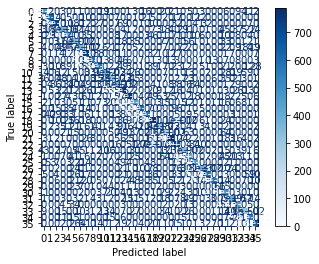

<Figure size 3600x3600 with 0 Axes>

                       precision    recall  f1-score   support

           allmorning       0.76      0.79      0.78       580
                 bird       0.81      0.85      0.83       721
                 blue       0.80      0.76      0.78       964
            cantsleep       0.60      0.61      0.60       616
                  cat       0.68      0.56      0.61       728
        coldrunnynose       0.47      0.61      0.53       600
continuouslyforanhour       0.78      0.59      0.67       619
                 cost       0.62      0.79      0.70       950
                  day       0.97      0.80      0.88       733
               dollar       0.70      0.65      0.68       860
         everymorning       0.75      0.65      0.70       604
           everynight       0.59      0.51      0.55       621
                 gold       0.82      0.53      0.65       675
            goodnight       0.57      0.74      0.65      1008
                happy       0.82      0.74      0.78  

In [15]:
# Normalized, Butterworth, PCA to SVM
clf = SVC()
clf.fit(x_t_train, y_train)
print ('score', clf.score(x_t_test, y_test))
y_pred=clf.predict(x_t_test)
print ('pred label', y_pred)
print('length',len(clf.predict(x_t_test)))

# Confusion matrix
plot_confusion_matrix(clf, x_t_test, y_test,
                                 cmap=plt.cm.Blues)
plt.figure(figsize=(50,50))
plt.show()

#metrics.classification_report(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=words))

TODO:

-check what happens when combining diff data sources

-graph components

find correlations

-interpret pca results

-try pca per individual/word

-read dataset papers

correlation component with word

-try straight to svm

-resend email

check what is the data

-merge timeseries word index

see how stable each feature are

standard deviation timeseries

-try without filter

multi-class classifier SVM



https://www.researchgate.net/publication/303707429_Combining_Smartphone_and_Smartwatch_Sensor_Data_in_Activity_Recognition_Approaches_an_Experimental_Evaluation

References

https://stackoverflow.com/questions/56449262/how-to-upload-folders-to-google-colab

https://github.com/datarail/datarail/issues/39

https://dbader.org/blog/python-check-if-file-exists

https://datacarpentry.org/python-socialsci/11-joins/index.html

https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html

https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html

https://stackoverflow.com/questions/32194967/how-to-do-pca-and-svm-for-classification-in-python

https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator

https://scikit-learn.org/stable/modules/cross_validation.html

https://stackoverflow.com/questions/47684606/merge-cells-with-pandas

https://scientificallysound.org/2016/08/18/python-analysing-emg-signals-part-3/

https://stackoverflow.com/questions/58374492/python-valueerror-the-length-of-the-input-vector-x-must-be-greater-than-padle

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

https://statinfer.com/204-4-2-calculating-sensitivity-and-specificity-in-python/

https://www.datacamp.com/community/tutorials/pandas-multi-index

https://www.geeksforgeeks.org/how-to-get-rows-index-names-in-pandas-dataframe/

https://stackoverflow.com/questions/28140771/select-only-one-index-of-multiindex-dataframe

https://www.educative.io/edpresso/how-to-create-a-confusion-matrix-in-python-using-scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

http://www.datasciencemadesimple.com/standard-deviation-function-python-pandas-row-column/

https://stackoverflow.com/questions/39047915/concat-series-onto-dataframe-with-column-name


In [16]:
"""
### Combine all files
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']
lengths=np.zeros(849, dtype=int)
reps=np.zeros(36,dtype=int)
wordnum=-1
counter=0

for w in words:
  repcount=0
  wordnum+=1

  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'

    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      lengths[counter-1]=len(trial)
      
      # Replace counter with evaluated term
      for r in range(0,len(trial)):
        trial.iloc[r,0]=wordnum
        
      # Combine all trials
      if path=='/content/2MyoASL/allmorning_10.csv':
          matrix=trial
          
          # Create plot for EMG

          # Create plot for accelerometer
          plt.figure()
          alx=plt.axes(projection='3d')
          alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
          alx.set_title('Accelerometer on left arm')

          plt.figure()
          arx=plt.axes(projection='3d')
          arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
          arx.set_title('Accelerometer on right arm')

          # Create plot for gyroscope
          plt.figure()
          glx=plt.axes(projection='3d')
          glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
          glx.set_title('Gyroscope on left arm')

          plt.figure()
          grx=plt.axes(projection='3d')
          grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          grx.set_title('Gyroscope on right arm')
      else:
          matrix=pd.concat([matrix, trial])

          ###############################################
          # Create plot for accelerometer
          alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
          arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
          #plt.show()

          # Create plot for gyroscope
          glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
          grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          ###############################################

  reps[wordnum]=repcount
plt.show()
""" 

"\n### Combine all files\nwords=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']\nlengths=np.zeros(849, dtype=int)\nreps=np.zeros(36,dtype=int)\nwordnum=-1\ncounter=0\n\nfor w in words:\n  repcount=0\n  wordnum+=1\n\n  for i in range (10, 120):\n    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'\n\n    if os.path.exists(path)==True:\n      counter+=1\n      repcount+=1\n      trial=pd.read_csv(path)\n      lengths[counter-1]=len(trial)\n      \n      # Replace counter with evaluated term\n      for r in range(0,len(trial)):\n        trial.iloc[r,0]=wordnum\n        \n      # Combine all trials\n      if path=='/content/2MyoASL

In [17]:
"""
# PCA for normmatrix
pca = PCA(n_components=35)
comp=pca.fit_transform(norm_matrix_eago)
principal=pd.DataFrame(data=comp, columns=['PC 0', 'PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8', 'PC 9', 'PC 10', 
                                           'PC 11', 'PC 12', 'PC 13', 'PC 14', 'PC 16', 'PC 17', 'PC 18', 'PC 19', 'PC 20', 
                                           'PC 21', 'PC 22', 'PC 23', 'PC 24', 'PC 25', 'PC 26', 'PC 27', 'PC 28', 'PC 29', 
                                           'PC 30', 'PC 31', 'PC 32', 'PC 33', 'PC 34', 'PC35'])
#principal.reset_index(drop=True, inplace=True)
#norm_matrix_eago[['Counter']].reset_index(drop=True, inplace=True)
norm_matrix_eago.reset_index(drop=True, inplace=True)
m.reset_index(drop=True, inplace=True)
#finaldf=pd.join([principal, norm_matrix_eago[['Counter']]], axis=1, ignore_index=True).reset_index()
finaldf=principal.join(m[['Counter']],how='outer')
finaldf=finaldf.drop(columns=['PC 0'])
####finaldf=principal
####print(m['Counter'])
####finaldf['Word']=m['Counter']
#finaldf=pd.concat([principal,norm_matrix_eago[['Counter']]], axis=1, ignore_index=True)

print("Normalized matrix")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn,pca.explained_variance_ratio_)
plt.show()
plt.bar(fn,pca.singular_values_)
plt.show()
print(finaldf)
#print(principal.join(norm_matrix_eago[['Counter']],how='inner'))
"""
"""
# PCA for normalizedmatrix
pca = PCA(n_components=34)
pca.fit(normalized_matrix)
print("Normalized features")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[0:34],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[0:34],pca.singular_values_)
plt.show()

# PCA for standardizedmatrix
pca = PCA(n_components=34)
pca.fit(standardized_matrix)
print("Standardized features")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[0:34],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[0:34],pca.singular_values_)
plt.show()
"""

'\n# PCA for normalizedmatrix\npca = PCA(n_components=34)\npca.fit(normalized_matrix)\nprint("Normalized features")\nprint(pca.explained_variance_ratio_)\nprint(pca.singular_values_)\nplt.figure()\nplt.bar(fn[0:34],pca.explained_variance_ratio_)\nplt.show()\nplt.bar(fn[0:34],pca.singular_values_)\nplt.show()\n\n# PCA for standardizedmatrix\npca = PCA(n_components=34)\npca.fit(standardized_matrix)\nprint("Standardized features")\nprint(pca.explained_variance_ratio_)\nprint(pca.singular_values_)\nplt.figure()\nplt.bar(fn[0:34],pca.explained_variance_ratio_)\nplt.show()\nplt.bar(fn[0:34],pca.singular_values_)\nplt.show()\n'